In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import planarity
from qplanarity import load_planar_graphs, generate_graphs, observable, get_trained_model, predict, analyse_pred
from tqdm.notebook import tqdm
from operator import itemgetter
from utils import Memoizer
import pandas as pd

Using backend: pytorch
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Planarity module

In [3]:
# Example of the complete graph of 5 nodes, K5
# K5 is not planar
edgelist = [('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'),
            ('b', 'c'),('b', 'd'),('b', 'e'),
            ('c', 'd'), ('c', 'e'),
            ('d', 'e')]

print(planarity.is_planar(edgelist))

# remove an edge to make the graph planar
edgelist.remove(('a','b'))
print(planarity.is_planar(edgelist))

# make an ascii text drawing
print(planarity.ascii(edgelist))

False
True
----1----
|  |    |
|  --5--|
|   || ||
--4--| ||
 ||  | ||
 |--3--||
 |    |||
 ---2----
         



## Planar graphs

In [4]:
%%time
n = 7 # 9 takes 2s already
graphs = load_planar_graphs(n)
print(len(graphs))
sorted(graphs[0].edges())

646
CPU times: user 15.1 ms, sys: 1.46 ms, total: 16.6 ms
Wall time: 16.4 ms


[(0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6)]

In [5]:
%%time
planars = 0
for graph in tqdm(graphs):
    planars += planarity.is_planar(graph)
assert planars == len(graphs)

  0%|          | 0/646 [00:00<?, ?it/s]

CPU times: user 26.1 ms, sys: 11.3 ms, total: 37.3 ms
Wall time: 37.4 ms


## Tests for development of key getter function for Memoizer

In [6]:
edges = list(map(sorted, graphs[1].edges()))
k1, k2 = tuple(map(tuple, sorted(edges, key=itemgetter(0,1)))), tuple(graphs[1].edges())
d = {}
d[k1] = 'test'  # can be used as key
k1, k2

(((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)),
 ((0, 6), (1, 6), (2, 6), (3, 6), (4, 5), (4, 6), (5, 6)))

## Graph generator

In [7]:
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from utils import return_list_of_states, return_energy_distribution, return_js_matrix, return_js_dist_matrix, entropy, merge_energies
from qutip import mcsolve, sesolve, sigmaz, sigmap, qeye, tensor, Options, expect, sigmam
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
from time import time

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize

In [8]:
np.random.seed(21)
graphs, targets = generate_graphs(range(3, 11), 2 * [50] + 3 * [100] + 3 * [200], generator='binomial', verbose=True)
graphs[:5], targets[:5]

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average


([<networkx.classes.graph.Graph at 0x110505160>,
 [True, True, True, True, True])

In [9]:
# graphs, targets = generate_graphs(7, 18)
# graphs[:5], targets[:5]

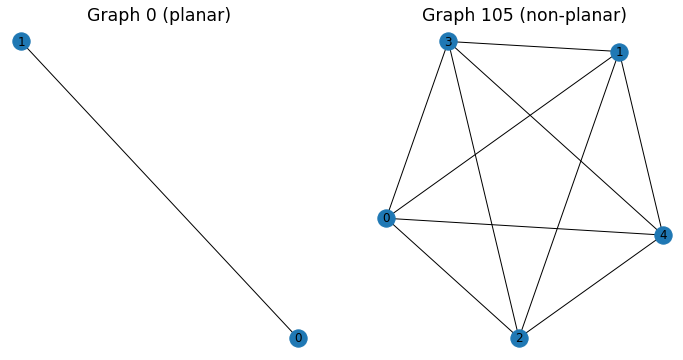

In [10]:
plt.figure(figsize=[12,6])
plt.subplot(121)
i_planar = targets.index(1)
nx.draw(graphs[i_planar], with_labels=True)
plt.title(f"Graph {i_planar} (planar)", fontsize='xx-large')
plt.subplot(122)
i_non_planar = targets.index(0)
nx.draw(graphs[i_non_planar], with_labels=True)
plt.title(f"Graph {i_non_planar} (non-planar)", fontsize='xx-large')
plt.show()

In [11]:
graphs[1].edges

EdgeView([(0, 1)])

## Generate the hamiltonian evolutions

We describe here how to perform a graph classification for specific values of times and pulses for a 2 layers ising evolution.

Generate the final states of all graphs 

In [12]:
times = [2.1, 1.6]
pulses = [0.2, 0.1]

states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot some final states after evolution

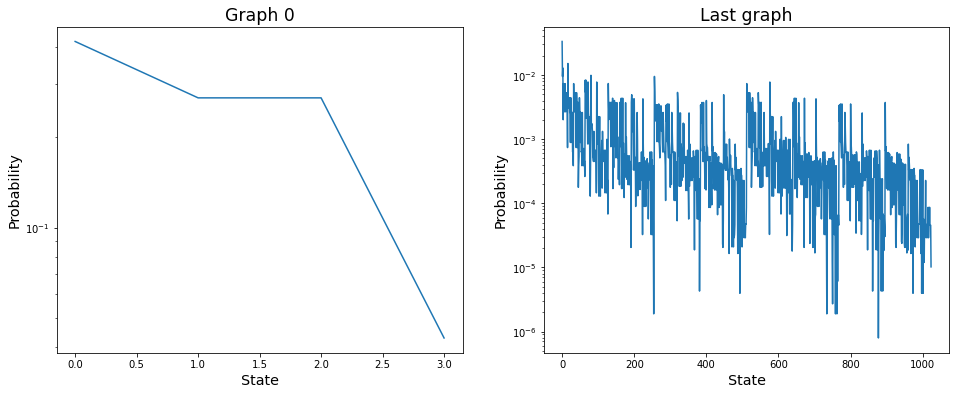

In [13]:
plt.figure(figsize=[16,6])
plt.subplot(121)
prob = np.abs(states[0].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
prob = np.abs(states[-1].data.toarray())**2
plt.plot(prob)
plt.yscale('log')
plt.xlabel('State', fontsize='x-large')
plt.ylabel('Probability', fontsize='x-large')
plt.title("Last graph", fontsize='xx-large')
plt.show()

Compute the probability distribution of the Ising observable from each state.

In [14]:
observables_memoizer = Memoizer(observable)

Compute the probability distribution and the distance matrix

In [15]:
energies_masses, energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, verbose=True, return_energies=True)
matrix = return_js_matrix(energies_masses)

  0%|          | 0/1000 [00:00<?, ?it/s]

Fit the model

In [16]:
K = np.exp(-matrix)
C_list = np.logspace(-3, 3, 7)

param_grid = {'C': C_list}
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score, average='weighted')
            }

skf = RepeatedStratifiedKFold(10, 10, random_state=47)

estimator = svm.SVC(kernel='precomputed', random_state=76)

grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                cv=skf, refit='accuracy', n_jobs=-1)
result = grid_search.fit(K, targets).cv_results_

i_best = np.argmax(result['mean_test_accuracy'])
print('Accuracy: ', result['mean_test_accuracy'][i_best], '±', result['std_test_accuracy'][i_best])


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy:  0.9975 ± 0.005722761571129804


5

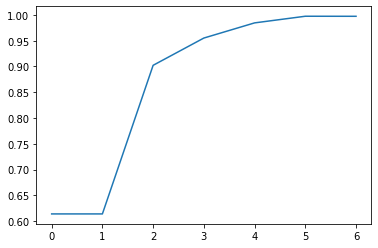

In [17]:
plt.plot(result['mean_test_accuracy'])
i_best

## Investigate generalisation capabilities

In [18]:
def tester(model, graphs, targets, energies_masses, energies):  
    times = [2.1, 1.6]
    pulses = [0.2, 0.1]

    states = return_list_of_states(graphs, times, pulses, evol='ising', verbose=1)
    _energies_masses, _energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable, return_energies=True, verbose=True)
    print(energies_masses.shape, _energies_masses.shape)
    energies_masses, _energies_masses = merge_energies(energies_masses, energies, _energies_masses, _energies)
    print(energies_masses.shape, _energies_masses.shape)
    print(energies.shape, _energies.shape)
    print(energies)
    # Should build correct test kernel | Ref.: https://stats.stackexchange.com/a/96881
    matrix = return_js_dist_matrix(_energies_masses, energies_masses, verbose=True)
    K = np.exp(-matrix)

    return model.predict(K), targets, model.score(K, targets)

In [19]:
merge_energies(np.array([[1, 2], [1, 2]]), [1, 2], np.array([[-1], [-1]]), [-1])

(array([[0., 1., 2.],
        [0., 1., 2.]]),
 array([[-1.,  0.,  0.],
        [-1.,  0.,  0.]]))

In [20]:
tester(grid_search, graphs, targets, energies_masses, energies)[2]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 54)
(1000, 54) (1000, 54)
(54,) (54,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

0.999

In [21]:
test_graphs, test_targets = generate_graphs([13], [10], generator='binomial')
test_graphs[:5], test_targets[:5]

([<networkx.classes.graph.Graph at 0x168e64b50>,
 [True, False, False, False, True])

In [22]:
tester(grid_search, test_graphs, test_targets, energies_masses, energies)[2]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(1000, 54) (10, 58)
(1000, 66) (10, 66)
(54,) (58,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

0.9

In [23]:
scores = []
ns = range(3, 8)
for n in ns:
    test_graphs, test_targets = generate_graphs([n], [1000], generator='binomial')
    y_pred, y_true, score = tester(grid_search, test_graphs, test_targets, energies_masses, energies)
    print(confusion_matrix(y_true, y_pred))
    print(f"\t### SCORE OF {score} FOR {n} NODES ###")
    scores.append(score)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 6)
(1000, 54) (1000, 54)
(54,) (6,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 10)
(1000, 54) (1000, 54)
(54,) (10,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[1000]]
	### SCORE OF 1.0 FOR 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 16)
(1000, 54) (1000, 54)
(54,) (16,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[220   0]
 [  0 780]]
	### SCORE OF 1.0 FOR 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 22)
(1000, 54) (1000, 54)
(54,) (22,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
	### SCORE OF 1.0 FOR 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 54) (1000, 31)
(1000, 54) (1000, 54)
(54,) (31,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[488   5]
 [  0 507]]
	### SCORE OF 0.995 FOR 7 NODES ###


Text(0.5, 0, 'Number of nodes')

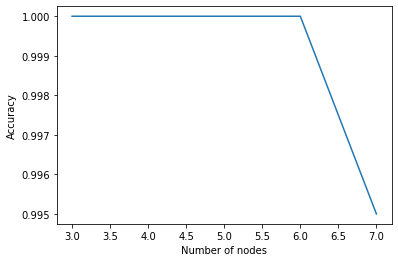

In [24]:
plt.plot(ns, scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of nodes')

In [25]:
planar_graphs = nx.read_graph6(f'datasets/planar_conn.{7}.g6')[:100]
tester(grid_search, planar_graphs, [1] * len(planar_graphs), energies_masses, energies)[2]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(1000, 54) (100, 24)
(1000, 54) (100, 54)
(54,) (24,)
[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  43.  44.  45.]


dist1 loop:   0%|          | 0/100 [00:00<?, ?it/s]

0.92

## Find the best parameters

Now we look for the values of times and pulses to get the best accuracy score. This is done by bayesian optimization.

Define the score function

In [26]:
def get_score(param):
    middle = len(param)//2
    states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)
    # skf = StratifiedKFold(5, shuffle=True, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets).cv_results_

    return -np.max(result['mean_test_accuracy'])
    


Run the bayesian optimization (can take up to 15 min)

In [27]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
    
opt_result = gp_minimize(
    get_score,
    bounds,
    acq_func='LCB',
    n_calls=30,
    n_initial_points=20,
    acq_optimizer='sampling',
    n_points=5000,
    kappa=4,
    n_jobs=-1,
    verbose=True)

Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 24.4644
Function value obtained: -0.9982
Current minimum: -0.9982
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.3313
Function value obtained: -0.9970
Current minimum: -0.9982
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 23.9739
Function value obtained: -0.9976
Current minimum: -0.9982
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.8756
Function value obtained: -0.9974
Current minimum: -0.9982
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 24.9410
Function value obtained: -0.9978
Current minimum: -0.9982
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 24.2763
Function value obtained: -0.9988
Current minimum: -0.9988
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 25.6776
Function value obtained: -0.9980
Current minimum: -0.9988
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 25.4148
Function value obtained: -0.9986
Current minimum: -0.9988
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 24.6598
Function value obtained: -0.9967
Current minimum: -0.9988
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 24.4488
Function value obtained: -0.9978
Current minimum: -0.9988
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 25.4010
Function value obtained: -0.9990
Current minimum: -0.9990
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 24.7986
Function value obtained: -0.9965
Current minimum: -0.9990
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 25.2790
Function value obtained: -0.9968
Current minimum: -0.9990
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 24.3663
Function value obtained: -0.9977
Current minimum: -0.9990
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 24.8039
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 24.1070
Function value obtained: -0.9969
Current minimum: -0.9990
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 24.4226
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 24.6561
Function value obtained: -0.9980
Current minimum: -0.9990
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 24.5116
Function value obtained: -0.9963
Current minimum: -0.9990
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 25.7986
Function value obtained: -0.9974
Current minimum: -0.9990
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 25.4562
Function value obtained: -0.9984
Current minimum: -0.9990
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 26.1670
Function value obtained: -0.9975
Current minimum: -0.9990
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 25.9196
Function value obtained: -0.9976
Current minimum: -0.9990
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 24.7869
Function value obtained: -0.9986
Current minimum: -0.9990
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 25.6673
Function value obtained: -0.9979
Current minimum: -0.9990
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 25.3340
Function value obtained: -0.9985
Current minimum: -0.9990
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 25.9732
Function value obtained: -0.9984
Current minimum: -0.9990
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 25.7441
Function value obtained: -0.9978
Current minimum: -0.9990
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 24.5401
Function value obtained: -0.9980
Current minimum: -0.9990
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 24.9106
Function value obtained: -0.9982
Current minimum: -0.9990


In [28]:
i_best = np.argmin(opt_result.func_vals)
print('Best accuracy: ', np.abs(opt_result.func_vals[i_best]))
print('Best parameters: ', opt_result.x_iters[i_best])

Best accuracy:  0.9989999999999999
Best parameters:  [1.3477293073265297, 0.4309718986961554, 0.9561314630934645, 0.7419091497350414]


# Scalability test

In [29]:
# > opt_result.x_iters[i_best]
# [1.3120541742020804, 1.1183939472347362, 0.6069423321714197, 0.774875787317455]
times = opt_result.x_iters[i_best][:2]
pulses = opt_result.x_iters[i_best][2:]


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average

	# 2. Train model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 99.900% ± 0.300% for C=1000.0


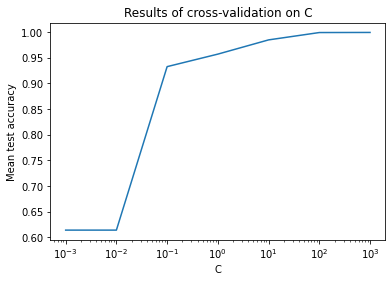

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[386   0]
 [  0 614]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       386
      Planar       1.00      1.00      1.00       614

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	# 4. Investigate generalisation capabilities


	#   a. 10 graphs of 20 nodes



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/10 [00:00<?, ?it/s]

[[8 1]
 [0 1]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.89      0.94         9
      Planar       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.75      0.94      0.80        10
weighted avg       0.95      0.90      0.91        10


	### Score: 90.00% (precision for planar: 0.500 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[218   0]
 [  0 782]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       218
      Planar       1.00      1.00      1.00       782

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[319   0]
 [  0 681]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       319
      Planar       1.00      1.00      1.00       681

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[489   0]
 [  5 506]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       489
      Planar       1.00      0.99      1.00       511

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


	### Score: 99.50% (precision for planar: 1.000 & non-planar: 0.990)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[445   0]
 [  0 555]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       445
      Planar       1.00      1.00      1.00       555

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[454   0]
 [  0 546]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       454
      Planar       1.00      1.00      1.00       546

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[537   0]
 [  0 463]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       537
      Planar       1.00      1.00      1.00       463

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[538  17]
 [ 32 413]]
              precision    recall  f1-score   support

  Non-planar       0.94      0.97      0.96       555
      Planar       0.96      0.93      0.94       445

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 95.10% (precision for planar: 0.960 & non-planar: 0.944)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[585   0]
 [ 11 404]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       585
      Planar       1.00      0.97      0.99       415

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.90% (precision for planar: 1.000 & non-planar: 0.982)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[590  11]
 [ 28 371]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.98      0.97       601
      Planar       0.97      0.93      0.95       399

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.10% (precision for planar: 0.971 & non-planar: 0.955)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[632   0]
 [ 55 313]]
              precision    recall  f1-score   support

  Non-planar       0.92      1.00      0.96       632
      Planar       1.00      0.85      0.92       368

    accuracy                           0.94      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 94.50% (precision for planar: 1.000 & non-planar: 0.920)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[612   0]
 [ 77 311]]
              precision    recall  f1-score   support

  Non-planar       0.89      1.00      0.94       612
      Planar       1.00      0.80      0.89       388

    accuracy                           0.92      1000
   macro avg       0.94      0.90      0.92      1000
weighted avg       0.93      0.92      0.92      1000


	### Score: 92.30% (precision for planar: 1.000 & non-planar: 0.888)

	### 16 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[641   0]
 [111 248]]
              precision    recall  f1-score   support

  Non-planar       0.85      1.00      0.92       641
      Planar       1.00      0.69      0.82       359

    accuracy                           0.89      1000
   macro avg       0.93      0.85      0.87      1000
weighted avg       0.91      0.89      0.88      1000


	### Score: 88.90% (precision for planar: 1.000 & non-planar: 0.852)

	### 17 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[765  17]
 [ 34 184]]
              precision    recall  f1-score   support

  Non-planar       0.96      0.98      0.97       782
      Planar       0.92      0.84      0.88       218

    accuracy                           0.95      1000
   macro avg       0.94      0.91      0.92      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.90% (precision for planar: 0.915 & non-planar: 0.957)

	### 18 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[778  44]
 [ 37 141]]
              precision    recall  f1-score   support

  Non-planar       0.95      0.95      0.95       822
      Planar       0.76      0.79      0.78       178

    accuracy                           0.92      1000
   macro avg       0.86      0.87      0.86      1000
weighted avg       0.92      0.92      0.92      1000


	### Score: 91.90% (precision for planar: 0.762 & non-planar: 0.955)


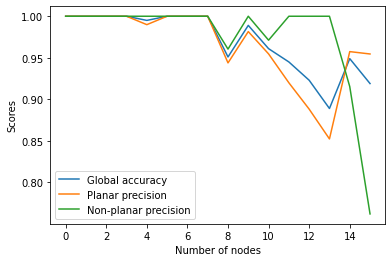

[(1.0, 1, 1),
 (1.0, 1, 1),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.995, 0.9898785425101214, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.951, 0.9438596491228071, 0.9604651162790697),
 (0.989, 0.9815436241610739, 1.0),
 (0.961, 0.9546925566343042, 0.9712041884816754),
 (0.945, 0.9199417758369723, 1.0),
 (0.923, 0.888243831640058, 1.0),
 (0.889, 0.8523936170212766, 1.0),
 (0.949, 0.9574468085106383, 0.9154228855721394),
 (0.919, 0.9546012269938651, 0.7621621621621621)]

In [30]:
from qplanarity import test_suite

# times = [2.1, 1.6]
# pulses = [0.2, 0.1]
train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'

test_suite(times, pulses, train_ns, train_nbs, generator, seed=21)

In [31]:
times_taken = [0, 0, 0, 4, 6, 7, 8, 10, 12, 15, 22, 36, 63, 115, 223, 506]

In [32]:
def time_required(n_max):
    assert n_max >= 11, 'Useless for small number of nodes'
    low = 10 * 5 # 3 to 7
    med = 30 * 4 # 8 to 11
    high = 32 * 2**(n_max - 11 + 1) # + 1 as it is the sum of all the powers of 2 below
    tot = low + med + high
    print(f"{tot}s = {tot / 60:.2f}m = {tot/3600:.2f}h")
    return tot

In [33]:
time_required(len(times_taken) - 1), sum(times_taken)

1194s = 19.90m = 0.33h


(1194, 1027)

In [34]:
time_required(18)

8362s = 139.37m = 2.32h


8362

# Scalability optimisation test

In [35]:
def get_score(param):
    """ 
    Uses global graphs, targets and observables_memoizer
    """
    middle = len(param)//2
    states = return_list_of_states(graphs, param[0:middle], param[middle::], evol='ising')
    energies = return_energy_distribution(graphs, states, observables_memoizer.get_observable)
    matrix = return_js_matrix(energies)
    K = np.exp(-matrix)
    C_list = np.logspace(-3, 3, 7)

    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
               'f1_score': make_scorer(f1_score, average='weighted')}

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)
    estimator = svm.SVC(kernel='precomputed', random_state=76)
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets).cv_results_
    return -np.max(result['mean_test_accuracy'])
    



	### 5 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.6863
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.8641
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.1021
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.7861
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.0367
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 12.9603
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.1352
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 12.8309
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 12.8884
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 12.9067
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 12.8465
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 12.9435
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 12.9336
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 12.8859
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 12.7597
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 12.9935
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 12.7979
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 12.9700
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 13.0054
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 13.0103
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 13.0037
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.0257
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 13.0873
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 12.8281
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 12.9708
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 13.2324
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 12.9696
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 12.7953
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 13.0341
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 13.0433
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.7813339865734936, 2.9467572571282425] and pulses [0.5287983037558911, 0.9995607379791867]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=0.1


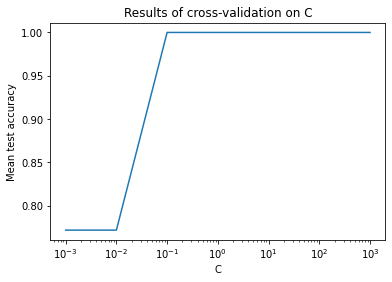

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[191   0]
 [  0 809]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       191
      Planar       1.00      1.00      1.00       809

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.5921
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.4516
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.6045
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.3907
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.5301
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 14.5276
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.5029
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.3224
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 14.3558
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 14.4924
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.4738
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 14.5448
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 14.4735
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 14.6138
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 14.3883
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 14.3886
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 14.4917
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 14.6592
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 14.5773
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 14.4190
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 14.7380
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 14.6689
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 14.5158
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 14.5255
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 14.4814
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 14.4322
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 14.6619
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 14.4769
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 14.4512
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 14.4589
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [0.7618240376371817, 0.7853396882643708] and pulses [0.7536841815829394, 0.021264236079320712]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=0.1


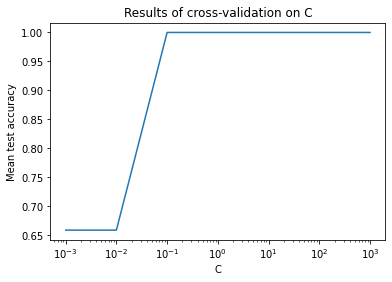

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[325   0]
 [  0 675]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       325
      Planar       1.00      1.00      1.00       675

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 17.3275
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.1784
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.1116
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 17.4677
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 17.1249
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 17.2098
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 17.3792
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 17.5248
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 17.0898
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 17.0809
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 17.2041
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 17.5237
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 17.2305
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 17.1475
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 17.2802
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 16.9508
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 17.3328
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 17.3328
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 17.5307
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 17.2574
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 17.2570
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 17.2097
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 17.5451
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 17.0931
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 17.5082
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 17.3091
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 16.9269
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 16.9238
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 17.3160
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 17.5397
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [1.9251665108542466, 1.4472736795867482] and pulses [0.7082760041547378, 0.43295472688823733]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


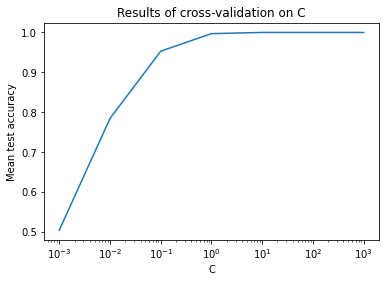

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[533   0]
 [  0 467]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       533
      Planar       1.00      1.00      1.00       467

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 8 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.9029
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.8252
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.9543
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 19.1871
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 19.2800
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 19.2973
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 19.1596
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 19.3006
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 19.0119
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 18.4744
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 18.6606
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 19.0624
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 18.5616
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 19.0539
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 18.6744
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 19.3905
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 18.7617
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 18.9538
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 18.7476
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 19.0092
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 18.3349
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 18.9639
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 19.4406
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 18.9644
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 18.5254
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 19.3062
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.4028
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 18.8625
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 19.0003
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 18.4836
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.170903944607627, 2.422455085930542] and pulses [0.35978643826909723, 0.3458155843489276]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


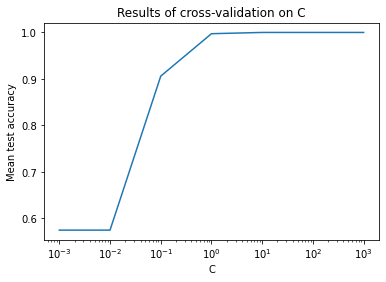

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[425   0]
 [  1 574]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       425
      Planar       1.00      1.00      1.00       575

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 99.90% (precision for planar: 1.000 & non-planar: 0.998)

	### 9 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.1031
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.0844
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.0647
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.4432
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 22.5964
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 22.1268
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 21.6945
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 22.4904
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 22.5456
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 21.6568
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 22.3293
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 22.4196
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 22.0090
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 21.4533
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 21.7246
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 22.3868
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 22.2693
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 21.6354
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 21.9385
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 22.0446
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 22.4991
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 22.2144
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 21.5574
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 22.4079
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 23.0610
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 23.2640
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 22.7079
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 22.7861
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 22.4087
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 22.3259
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [1.8358480583431898, 2.227987454473109] and pulses [0.5772104563042437, 0.8231488535285473]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


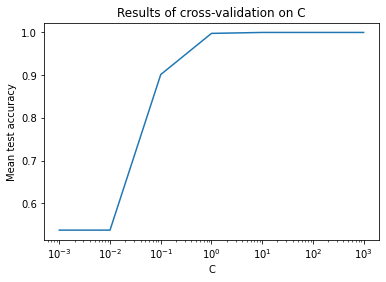

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[476   0]
 [  0 524]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       476
      Planar       1.00      1.00      1.00       524

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 10 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 28.9010
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.6067
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 28.9472
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 27.7251
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 26.9973
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 28.5500
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 27.9375
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 28.4682
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 28.7566
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 29.2869
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 28.1275
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 29.2117
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 28.0831
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 29.3043
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 28.4070
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 28.3298
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 29.1644
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 27.9064
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 29.2159
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 27.7348
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 27.0596
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 30.3143
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 28.5352
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 28.2785
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 30.2434
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 29.9264
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 26.6856
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 28.3480
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 28.2045
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 26.7293
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [1.6061186888796333, 0.8214683614328437] and pulses [0.7528598654297034, 0.1746238521994489]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=1.0


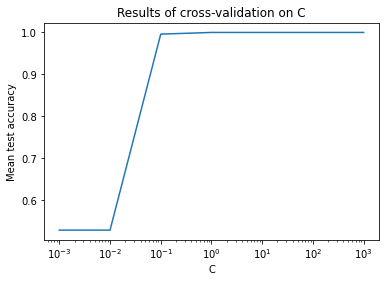

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[499   1]
 [  0 500]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       500
      Planar       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 99.90% (precision for planar: 0.998 & non-planar: 1.000)

	### 11 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 46.2016
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 40.3914
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 42.8304
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 39.9481
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 41.8347
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 43.8438
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 42.8631
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 42.3805
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 43.2311
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 45.5413
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 40.3670
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 42.1773
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 42.8344
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 40.8244
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 43.2912
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 39.5379
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 42.5655
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 40.1211
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 41.5129
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 42.7442
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 38.4247
Function value obtained: -0.9998
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 45.6685
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 40.3086
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 44.1639
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 42.0460
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 39.7815
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 41.6150
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 41.7874
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 43.6199
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 41.8458
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.7495042174200406, 1.6926740733796042] and pulses [0.8292143747687263, 0.9957917166109468]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


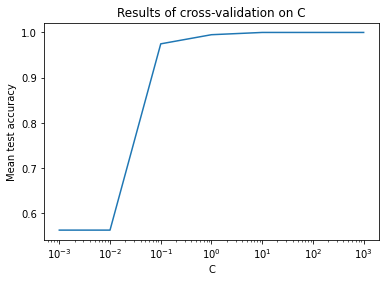

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[583   0]
 [  0 417]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       583
      Planar       1.00      1.00      1.00       417

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 12 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.7815
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 60.5924
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 65.8356
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 67.1640
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 66.2867
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 66.2873
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 62.6201
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 62.3671
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 65.7267
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 62.6323
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 64.6082
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 68.1994
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 63.8347
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 65.1572
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 62.6997
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 62.3662
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 69.0656
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 65.4027
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 70.1565
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 62.7769
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 73.5411
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 63.9794
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 64.9654
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 57.7418
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 72.3598
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 62.8166
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 58.0263
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 65.9078
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 67.9023
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 64.2175
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [0.2641521386312497, 1.9877687336266434] and pulses [0.7801667894949249, 0.34598126084833075]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


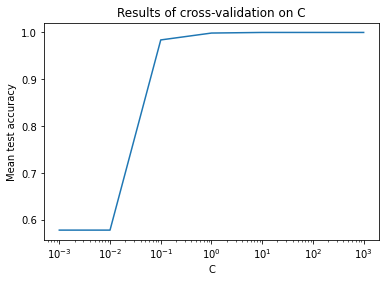

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[567   0]
 [  0 433]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       567
      Planar       1.00      1.00      1.00       433

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 13 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 121.5016
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 105.6179
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 117.0953
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 110.7921
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 109.0335
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 119.4390
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 99.5134
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 117.5412
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 109.1487
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 108.3555
Function value obtained: -0.9980
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 98.5523
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 102.6327
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 104.6151
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 109.1794
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 120.6517
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 127.4871
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 109.6918
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 102.3518
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 117.0782
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 115.5134
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 120.3236
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 106.8420
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 112.6276
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 104.0411
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 106.7172
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 115.9714
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 116.0396
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 110.8609
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 113.4482
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 105.4675
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [0.9536056671804556, 2.0079590351742116] and pulses [0.9658598829651168, 0.38260757723926797]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=1.0


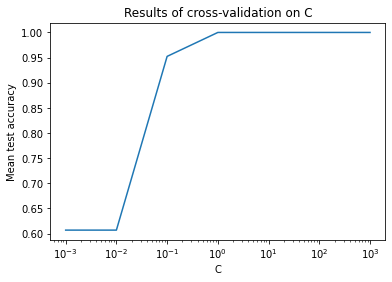

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[621   0]
 [  0 379]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       621
      Planar       1.00      1.00      1.00       379

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 14 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 241.2349
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 194.0052
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 197.3165
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 209.9173
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 215.1898
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 229.9646
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 194.4677
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 187.4179
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 211.2012
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 206.5571
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 215.9636
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 205.5940
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 191.8963
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 220.5275
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 218.2396
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 209.4520
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 225.9010
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 192.3147
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 208.8382
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 192.1550
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 197.5685
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 192.4520
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 182.8689
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 206.4377
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 208.7760
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 170.8192
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 209.5085
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 198.9367
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 238.0744
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 195.2526
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [0.6129493870436009, 1.5390917649697413] and pulses [0.8239351654309355, 0.9964342312811735]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=10.0


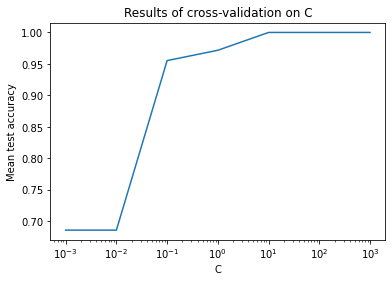

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[676   0]
 [  0 324]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       676
      Planar       1.00      1.00      1.00       324

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)

	### 15 NODES ###
Iteration No: 1 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 503.6683
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 453.4361
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 500.2858
Function value obtained: -0.9997
Current minimum: -1.0000
Iteration No: 4 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 444.3318
Function value obtained: -0.9985
Current minimum: -1.0000
Iteration No: 5 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 429.1468
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 443.9933
Function value obtained: -0.9985
Current minimum: -1.0000
Iteration No: 7 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 503.3112
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 427.3222
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 473.7849
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 474.6862
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 454.4641
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 473.1899
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 433.5225
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 14 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 393.9940
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 458.1580
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 16 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 514.7301
Function value obtained: -0.9995
Current minimum: -1.0000
Iteration No: 17 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 504.5576
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 498.3883
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 455.7402
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Evaluating function at random point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 462.5287
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 21 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 423.4424
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 22 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 450.1619
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 23 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 450.6733
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 24 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 494.3662
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 25 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 480.9641
Function value obtained: -0.9990
Current minimum: -1.0000
Iteration No: 26 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 443.5398
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 27 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 514.6867
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 28 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 512.7888
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 29 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 472.6170
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 30 started. Searching for the next optimal point.


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 380.8037
Function value obtained: -1.0000
Current minimum: -1.0000
Score 100.0% obtained for times [2.2339736031941113, 0.3802521417960637] and pulses [0.9057185791435366, 0.42720947757980965]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 100.000% ± 0.000% for C=1.0


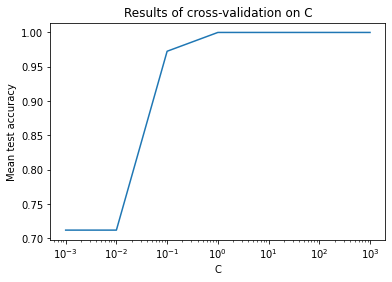

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[678   0]
 [  0 322]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       678
      Planar       1.00      1.00      1.00       322

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (precision for planar: 1.000 & non-planar: 1.000)


In [36]:
bounds = [(0., 3.)] * 2 + [(0., 1.)] * 2
verbose = True
metric = 'precision'

scores = []
ns = range(5, 16)
N = 1000
for n in ns:
    if verbose: print(f"\n\t### {n} NODES ###")
    # Generate data
    graphs, targets = generate_graphs([n], [N], generator='binomial')
    observables_memoizer = Memoizer(observable)
    # Find optimized parameters
    opt_result = gp_minimize(
        get_score,
        bounds,
        acq_func='LCB',
        n_calls=30,
        n_initial_points=20,
        acq_optimizer='sampling',
        n_points=5000,
        kappa=4,
        n_jobs=-1,
        verbose=True
    )
    i_best = np.argmin(opt_result.func_vals)
    score = np.abs(opt_result.func_vals[i_best])
    times = opt_result.x_iters[i_best][:2]
    pulses = opt_result.x_iters[i_best][2:]
    if verbose:
        print(f"Score {score:6.1%} obtained for times {times} and pulses {pulses}")
    
    # Get trained model with found parameters
    model, energies_masses, energies = get_trained_model(times, pulses, graphs, targets, verbose=True)
    
    # Use model to predict on test data
    test_graphs, test_targets = generate_graphs([n], [N], generator='binomial')
    y_pred, y_true, score = predict(model, times, pulses, test_graphs, test_targets, energies_masses, energies, verbose=verbose)
    
    score_p, score_np = analyse_pred(y_pred, y_true, score, metric=metric, verbose=verbose)
    scores.append((score, score_p[metric], score_np[metric]))

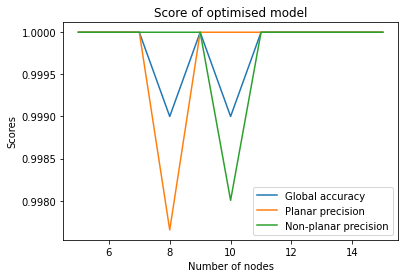

In [41]:
# Plot scores
pd.DataFrame(scores, columns=['Global accuracy', f'Planar {metric}', f'Non-planar {metric}'], index=ns).plot()
plt.ylabel('Scores')
plt.xlabel('Number of nodes')
plt.title('Score of optimised model')
plt.legend()
plt.show()

In [39]:
# 1 iteration with N=1000 at n=5 takes 14s
# -> x30 = 7m
# 1 iteration with N=1000 at n=10 takes 29s
# -> x30 = 15m
# 1 iteration with N=1000 at n=15 takes more than 3min...
# -> x30 = 
# 1 iteration with N=1000 at n=8 takes 20s
# -> x30 = 10m
# 6h=360m / 30 
# Limit to 10: 7 + 9 + 9 + 10 + 13 + 15 = 63

In [40]:
# Do a loop: train until n predict until 15 and see what happens

# Train on different n

In [48]:
def generate_nbs(min_n, max_n, N_tot):
    # Both included
    nb_ns = max_n - min_n + 1
    ns = np.array(range(min_n, max_n + 1))
    return list(map(round, N_tot * ns / sum(ns)))

nbs = generate_nbs(3, 10, 1000)
nbs, sum(nbs)

([58, 77, 96, 115, 135, 154, 173, 192], 1000)

  0%|          | 0/11 [00:00<?, ?it/s]


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  80.0% planar in average
Generated graphs are at  80.0% planar in average

	# 2. Train model



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The

Accuracy: 100.000% ± 0.000% for C=1.0


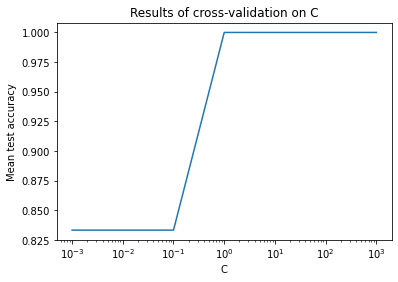

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/25 [00:00<?, ?it/s]

[[ 5  0]
 [ 0 20]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00         5
      Planar       1.00      1.00      1.00        20

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[197   0]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       197
      Planar       1.00      1.00      1.00       803

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0  98]
 [502 400]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00        98
      Planar       0.80      0.44      0.57       902

    accuracy                           0.40      1000
   macro avg       0.40      0.22      0.29      1000
weighted avg       0.72      0.40      0.52      1000


	### Score: 40.00% (f1-score for planar: 0.571 & non-planar: 0.000)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

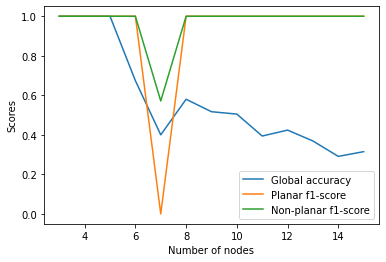


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  76.5% planar in average
Generated graphs with   6 nodes are at  63.6% planar in average
Generated graphs are at  69.2% planar in average

	# 2. Train model



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 97.417% ± 7.790% for C=10.0


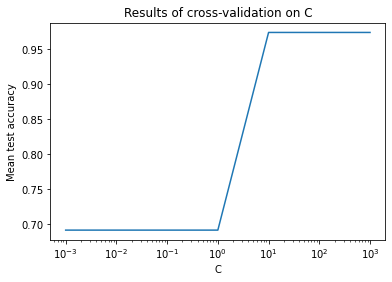

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/39 [00:00<?, ?it/s]

[[12  0]
 [ 0 27]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        12
      Planar       1.00      1.00      1.00        27

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 278]
 [  0 722]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       278
      Planar       0.72      1.00      0.84       722

    accuracy                           0.72      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.52      0.72      0.61      1000


	### Score: 72.20% (f1-score for planar: 0.839 & non-planar: 0.000)

	### 4 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196   0]
 [  0 804]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       196
      Planar       1.00      1.00      1.00       804

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[328   0]
 [  0 672]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       328
      Planar       1.00      1.00      1.00       672

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[209  96]
 [295 400]]
              precision    recall  f1-score   support

  Non-planar       0.41      0.69      0.52       305
      Planar       0.81      0.58      0.67       695

    accuracy                           0.61      1000
   macro avg       0.61      0.63      0.59      1000
weighted avg       0.69      0.61      0.62      1000


	### Score: 60.90% (f1-score for planar: 0.672 & non-planar: 0.517)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196  87]
 [221 496]]
              precision    recall  f1-score   support

  Non-planar       0.47      0.69      0.56       283
      Planar       0.85      0.69      0.76       717

    accuracy                           0.69      1000
   macro avg       0.66      0.69      0.66      1000
weighted avg       0.74      0.69      0.71      1000


	### Score: 69.20% (f1-score for planar: 0.763 & non-planar: 0.560)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[ 98   0]
 [387 515]]
              precision    recall  f1-score   support

  Non-planar       0.20      1.00      0.34        98
      Planar       1.00      0.57      0.73       902

    accuracy                           0.61      1000
   macro avg       0.60      0.79      0.53      1000
weighted avg       0.92      0.61      0.69      1000


	### Score: 61.30% (f1-score for planar: 0.727 & non-planar: 0.336)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[286   0]
 [207 507]]
              precision    recall  f1-score   support

  Non-planar       0.58      1.00      0.73       286
      Planar       1.00      0.71      0.83       714

    accuracy                           0.79      1000
   macro avg       0.79      0.86      0.78      1000
weighted avg       0.88      0.79      0.80      1000


	### Score: 79.30% (f1-score for planar: 0.830 & non-planar: 0.734)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[289   0]
 [318 393]]
              precision    recall  f1-score   support

  Non-planar       0.48      1.00      0.65       289
      Planar       1.00      0.55      0.71       711

    accuracy                           0.68      1000
   macro avg       0.74      0.78      0.68      1000
weighted avg       0.85      0.68      0.69      1000


	### Score: 68.20% (f1-score for planar: 0.712 & non-planar: 0.645)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[405  17]
 [172 406]]
              precision    recall  f1-score   support

  Non-planar       0.70      0.96      0.81       422
      Planar       0.96      0.70      0.81       578

    accuracy                           0.81      1000
   macro avg       0.83      0.83      0.81      1000
weighted avg       0.85      0.81      0.81      1000


	### Score: 81.10% (f1-score for planar: 0.811 & non-planar: 0.811)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629  11]
 [  3 357]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.98      0.99       640
      Planar       0.97      0.99      0.98       360

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 98.60% (f1-score for planar: 0.981 & non-planar: 0.989)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[685   0]
 [ 22 293]]
              precision    recall  f1-score   support

  Non-planar       0.97      1.00      0.98       685
      Planar       1.00      0.93      0.96       315

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.964 & non-planar: 0.984)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[624  26]
 [ 58 292]]
              precision    recall  f1-score   support

  Non-planar       0.91      0.96      0.94       650
      Planar       0.92      0.83      0.87       350

    accuracy                           0.92      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.92      0.92      0.91      1000


	### Score: 91.60% (f1-score for planar: 0.874 & non-planar: 0.937)


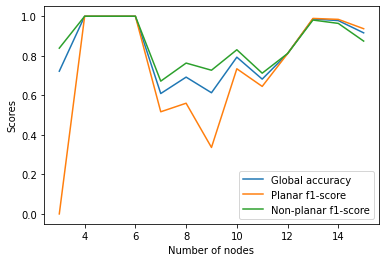


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  75.0% planar in average
Generated graphs with   6 nodes are at  68.8% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs are at  62.5% planar in average

	# 2. Train model



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 97.350% ± 7.432% for C=100.0


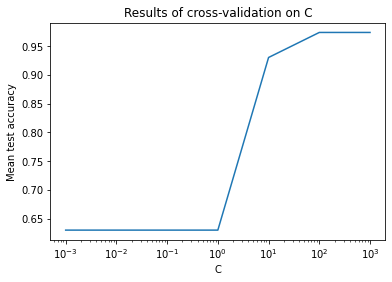

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/48 [00:00<?, ?it/s]

[[18  0]
 [ 0 30]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        18
      Planar       1.00      1.00      1.00        30

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 277]
 [  0 723]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       277
      Planar       0.72      1.00      0.84       723

    accuracy                           0.72      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.52      0.72      0.61      1000


	### Score: 72.30% (f1-score for planar: 0.839 & non-planar: 0.000)

	### 4 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 213]
 [  0 787]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       213
      Planar       0.79      1.00      0.88       787

    accuracy                           0.79      1000
   macro avg       0.39      0.50      0.44      1000
weighted avg       0.62      0.79      0.69      1000


	### Score: 78.70% (f1-score for planar: 0.881 & non-planar: 0.000)

	### 5 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[197   0]
 [  0 803]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       197
      Planar       1.00      1.00      1.00       803

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[327  48]
 [  0 625]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.87      0.93       375
      Planar       0.93      1.00      0.96       625

    accuracy                           0.95      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.20% (f1-score for planar: 0.963 & non-planar: 0.932)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[365  96]
 [141 398]]
              precision    recall  f1-score   support

  Non-planar       0.72      0.79      0.75       461
      Planar       0.81      0.74      0.77       539

    accuracy                           0.76      1000
   macro avg       0.76      0.77      0.76      1000
weighted avg       0.77      0.76      0.76      1000


	### Score: 76.30% (f1-score for planar: 0.771 & non-planar: 0.755)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[364  96]
 [ 54 486]]
              precision    recall  f1-score   support

  Non-planar       0.87      0.79      0.83       460
      Planar       0.84      0.90      0.87       540

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


	### Score: 85.00% (f1-score for planar: 0.866 & non-planar: 0.829)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[445  48]
 [ 38 469]]
              precision    recall  f1-score   support

  Non-planar       0.92      0.90      0.91       493
      Planar       0.91      0.93      0.92       507

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000


	### Score: 91.40% (f1-score for planar: 0.916 & non-planar: 0.912)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[497  75]
 [  0 428]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.87      0.93       572
      Planar       0.85      1.00      0.92       428

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.94      0.93      0.93      1000


	### Score: 92.50% (f1-score for planar: 0.919 & non-planar: 0.930)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[605 101]
 [  0 294]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.86      0.92       706
      Planar       0.74      1.00      0.85       294

    accuracy                           0.90      1000
   macro avg       0.87      0.93      0.89      1000
weighted avg       0.92      0.90      0.90      1000


	### Score: 89.90% (f1-score for planar: 0.853 & non-planar: 0.923)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[577 116]
 [  0 307]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.83      0.91       693
      Planar       0.73      1.00      0.84       307

    accuracy                           0.88      1000
   macro avg       0.86      0.92      0.87      1000
weighted avg       0.92      0.88      0.89      1000


	### Score: 88.40% (f1-score for planar: 0.841 & non-planar: 0.909)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[631 108]
 [  0 261]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.85      0.92       739
      Planar       0.71      1.00      0.83       261

    accuracy                           0.89      1000
   macro avg       0.85      0.93      0.87      1000
weighted avg       0.92      0.89      0.90      1000


	### Score: 89.20% (f1-score for planar: 0.829 & non-planar: 0.921)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[706  25]
 [  0 269]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.98       731
      Planar       0.91      1.00      0.96       269

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.97      0.98      1000


	### Score: 97.50% (f1-score for planar: 0.956 & non-planar: 0.983)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[683  55]
 [  0 262]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.93      0.96       738
      Planar       0.83      1.00      0.91       262

    accuracy                           0.94      1000
   macro avg       0.91      0.96      0.93      1000
weighted avg       0.95      0.94      0.95      1000


	### Score: 94.50% (f1-score for planar: 0.905 & non-planar: 0.961)


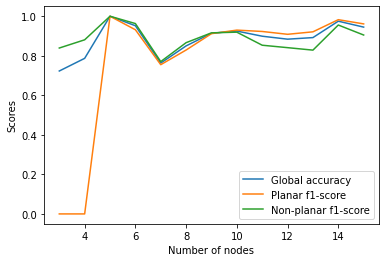


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  77.8% planar in average
Generated graphs with   6 nodes are at  50.0% planar in average
Generated graphs with   7 nodes are at  60.0% planar in average
Generated graphs with   8 nodes are at  44.4% planar in average
Generated graphs are at  55.6% planar in average

	# 2. Train model



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 87.333% ± 14.283% for C=100.0


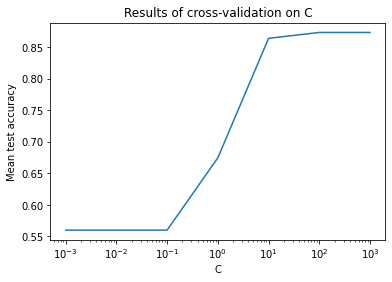

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/54 [00:00<?, ?it/s]

[[24  0]
 [ 0 30]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        24
      Planar       1.00      1.00      1.00        30

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 212]
 [  0 788]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       212
      Planar       0.79      1.00      0.88       788

    accuracy                           0.79      1000
   macro avg       0.39      0.50      0.44      1000
weighted avg       0.62      0.79      0.69      1000


	### Score: 78.80% (f1-score for planar: 0.881 & non-planar: 0.000)

	### 5 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[196   0]
 [  0 804]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00       196
      Planar       1.00      1.00      1.00       804

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[241   0]
 [ 87 672]]
              precision    recall  f1-score   support

  Non-planar       0.73      1.00      0.85       241
      Planar       1.00      0.89      0.94       759

    accuracy                           0.91      1000
   macro avg       0.87      0.94      0.89      1000
weighted avg       0.94      0.91      0.92      1000


	### Score: 91.30% (f1-score for planar: 0.939 & non-planar: 0.847)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[363   0]
 [142 495]]
              precision    recall  f1-score   support

  Non-planar       0.72      1.00      0.84       363
      Planar       1.00      0.78      0.87       637

    accuracy                           0.86      1000
   macro avg       0.86      0.89      0.86      1000
weighted avg       0.90      0.86      0.86      1000


	### Score: 85.80% (f1-score for planar: 0.875 & non-planar: 0.836)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[390   9]
 [ 29 572]]
              precision    recall  f1-score   support

  Non-planar       0.93      0.98      0.95       399
      Planar       0.98      0.95      0.97       601

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.20% (f1-score for planar: 0.968 & non-planar: 0.954)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[405  48]
 [ 76 471]]
              precision    recall  f1-score   support

  Non-planar       0.84      0.89      0.87       453
      Planar       0.91      0.86      0.88       547

    accuracy                           0.88      1000
   macro avg       0.87      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000


	### Score: 87.60% (f1-score for planar: 0.884 & non-planar: 0.867)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[499  75]
 [  0 426]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.87      0.93       574
      Planar       0.85      1.00      0.92       426

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.94      0.93      0.93      1000


	### Score: 92.50% (f1-score for planar: 0.919 & non-planar: 0.930)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[606  93]
 [  0 301]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.87      0.93       699
      Planar       0.76      1.00      0.87       301

    accuracy                           0.91      1000
   macro avg       0.88      0.93      0.90      1000
weighted avg       0.93      0.91      0.91      1000


	### Score: 90.70% (f1-score for planar: 0.866 & non-planar: 0.929)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[578 126]
 [  0 296]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.82      0.90       704
      Planar       0.70      1.00      0.82       296

    accuracy                           0.87      1000
   macro avg       0.85      0.91      0.86      1000
weighted avg       0.91      0.87      0.88      1000


	### Score: 87.40% (f1-score for planar: 0.825 & non-planar: 0.902)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630 127]
 [  0 243]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.83      0.91       757
      Planar       0.66      1.00      0.79       243

    accuracy                           0.87      1000
   macro avg       0.83      0.92      0.85      1000
weighted avg       0.92      0.87      0.88      1000


	### Score: 87.30% (f1-score for planar: 0.793 & non-planar: 0.908)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[706  26]
 [  0 268]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.96      0.98       732
      Planar       0.91      1.00      0.95       268

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.97      0.97      1000


	### Score: 97.40% (f1-score for planar: 0.954 & non-planar: 0.982)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[684  62]
 [  0 254]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.92      0.96       746
      Planar       0.80      1.00      0.89       254

    accuracy                           0.94      1000
   macro avg       0.90      0.96      0.92      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 93.80% (f1-score for planar: 0.891 & non-planar: 0.957)


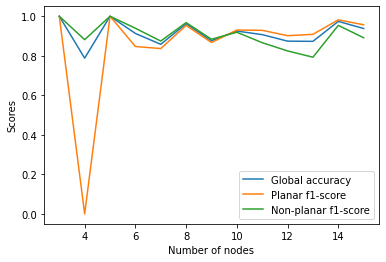


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  85.7% planar in average
Generated graphs with   6 nodes are at  50.0% planar in average
Generated graphs with   7 nodes are at  58.3% planar in average
Generated graphs with   8 nodes are at  35.7% planar in average
Generated graphs with   9 nodes are at  47.1% planar in average
Generated graphs are at  51.7% planar in average

	# 2. Train model



  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 94.167% ± 10.639% for C=100.0


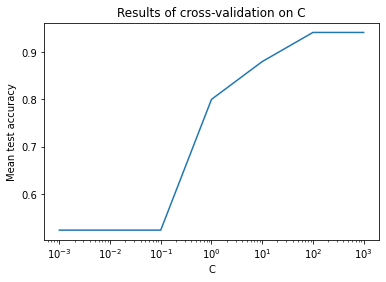

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/60 [00:00<?, ?it/s]

[[29  0]
 [ 0 31]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        29
      Planar       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 4 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]


	### 5 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[198  37]
 [  0 765]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.84      0.91       235
      Planar       0.95      1.00      0.98       765

    accuracy                           0.96      1000
   macro avg       0.98      0.92      0.95      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.30% (f1-score for planar: 0.976 & non-planar: 0.915)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239 152]
 [ 87 522]]
              precision    recall  f1-score   support

  Non-planar       0.73      0.61      0.67       391
      Planar       0.77      0.86      0.81       609

    accuracy                           0.76      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.76      0.76      0.76      1000


	### Score: 76.10% (f1-score for planar: 0.814 & non-planar: 0.667)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[499   0]
 [  5 496]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      1.00       499
      Planar       1.00      0.99      0.99       501

    accuracy                           0.99      1000
   macro avg       1.00      1.00      0.99      1000
weighted avg       1.00      0.99      0.99      1000


	### Score: 99.50% (f1-score for planar: 0.995 & non-planar: 0.995)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[416  10]
 [  5 569]]
              precision    recall  f1-score   support

  Non-planar       0.99      0.98      0.98       426
      Planar       0.98      0.99      0.99       574

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000


	### Score: 98.50% (f1-score for planar: 0.987 & non-planar: 0.982)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480  53]
 [  0 467]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.90      0.95       533
      Planar       0.90      1.00      0.95       467

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.70% (f1-score for planar: 0.946 & non-planar: 0.948)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[502  66]
 [  0 432]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.88      0.94       568
      Planar       0.87      1.00      0.93       432

    accuracy                           0.93      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.94      0.93      0.93      1000


	### Score: 93.40% (f1-score for planar: 0.929 & non-planar: 0.938)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[607 104]
 [  0 289]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.85      0.92       711
      Planar       0.74      1.00      0.85       289

    accuracy                           0.90      1000
   macro avg       0.87      0.93      0.88      1000
weighted avg       0.92      0.90      0.90      1000


	### Score: 89.60% (f1-score for planar: 0.848 & non-planar: 0.921)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[575 145]
 [  1 279]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.80      0.89       720
      Planar       0.66      1.00      0.79       280

    accuracy                           0.85      1000
   macro avg       0.83      0.90      0.84      1000
weighted avg       0.90      0.85      0.86      1000


	### Score: 85.40% (f1-score for planar: 0.793 & non-planar: 0.887)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629 133]
 [  0 238]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.83      0.90       762
      Planar       0.64      1.00      0.78       238

    accuracy                           0.87      1000
   macro avg       0.82      0.91      0.84      1000
weighted avg       0.91      0.87      0.88      1000


	### Score: 86.70% (f1-score for planar: 0.782 & non-planar: 0.904)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[705  44]
 [  0 251]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.94      0.97       749
      Planar       0.85      1.00      0.92       251

    accuracy                           0.96      1000
   macro avg       0.93      0.97      0.94      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 95.60% (f1-score for planar: 0.919 & non-planar: 0.970)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[684  62]
 [  0 254]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.92      0.96       746
      Planar       0.80      1.00      0.89       254

    accuracy                           0.94      1000
   macro avg       0.90      0.96      0.92      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 93.80% (f1-score for planar: 0.891 & non-planar: 0.957)


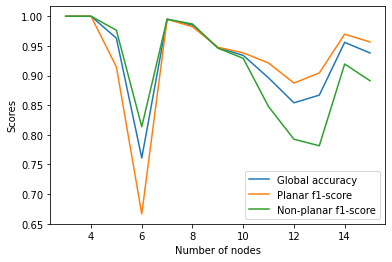


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  37.5% planar in average
Generated graphs with   7 nodes are at  60.0% planar in average
Generated graphs with   8 nodes are at  50.0% planar in average
Generated graphs with   9 nodes are at  46.2% planar in average
Generated graphs with  10 nodes are at  40.0% planar in average
Generated graphs are at  51.6% planar in average

	# 2. Train model



  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 91.286% ± 11.665% for C=100.0


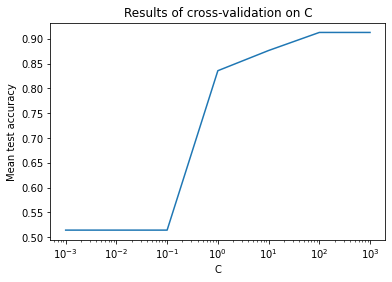

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/64 [00:00<?, ?it/s]

[[31  0]
 [ 0 33]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        31
      Planar       1.00      1.00      1.00        33

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 280]
 [  0 720]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       280
      Planar       0.72      1.00      0.84       720

    accuracy                           0.72      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.52      0.72      0.60      1000


	### Score: 72.00% (f1-score for planar: 0.837 & non-planar: 0.000)

	### 4 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 532]
 [  0 468]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       532
      Planar       0.47      1.00      0.64       468

    accuracy                           0.47      1000
   macro avg       0.23      0.50      0.32      1000
weighted avg       0.22      0.47      0.30      1000


	### Score: 46.80% (f1-score for planar: 0.638 & non-planar: 0.000)

	### 5 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0  37]
 [198 765]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00        37
      Planar       0.95      0.79      0.87       963

    accuracy                           0.77      1000
   macro avg       0.48      0.40      0.43      1000
weighted avg       0.92      0.77      0.83      1000


	### Score: 76.50% (f1-score for planar: 0.867 & non-planar: 0.000)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239 153]
 [ 87 521]]
              precision    recall  f1-score   support

  Non-planar       0.73      0.61      0.67       392
      Planar       0.77      0.86      0.81       608

    accuracy                           0.76      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.76      0.76      0.76      1000


	### Score: 76.00% (f1-score for planar: 0.813 & non-planar: 0.666)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[497   0]
 [  8 495]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       497
      Planar       1.00      0.98      0.99       503

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.20% (f1-score for planar: 0.992 & non-planar: 0.992)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[331  10]
 [ 89 570]]
              precision    recall  f1-score   support

  Non-planar       0.79      0.97      0.87       341
      Planar       0.98      0.86      0.92       659

    accuracy                           0.90      1000
   macro avg       0.89      0.92      0.90      1000
weighted avg       0.92      0.90      0.90      1000


	### Score: 90.10% (f1-score for planar: 0.920 & non-planar: 0.870)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480  54]
 [  0 466]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.90      0.95       534
      Planar       0.90      1.00      0.95       466

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.60% (f1-score for planar: 0.945 & non-planar: 0.947)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[501  22]
 [  0 477]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.96      0.98       523
      Planar       0.96      1.00      0.98       477

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.80% (f1-score for planar: 0.977 & non-planar: 0.979)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[608  18]
 [  0 374]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.97      0.99       626
      Planar       0.95      1.00      0.98       374

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.20% (f1-score for planar: 0.977 & non-planar: 0.985)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[562 102]
 [ 14 322]]
              precision    recall  f1-score   support

  Non-planar       0.98      0.85      0.91       664
      Planar       0.76      0.96      0.85       336

    accuracy                           0.88      1000
   macro avg       0.87      0.90      0.88      1000
weighted avg       0.90      0.88      0.89      1000


	### Score: 88.40% (f1-score for planar: 0.847 & non-planar: 0.906)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[629  88]
 [  0 283]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.88      0.93       717
      Planar       0.76      1.00      0.87       283

    accuracy                           0.91      1000
   macro avg       0.88      0.94      0.90      1000
weighted avg       0.93      0.91      0.92      1000


	### Score: 91.20% (f1-score for planar: 0.865 & non-planar: 0.935)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[704   7]
 [  0 289]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.99      1.00       711
      Planar       0.98      1.00      0.99       289

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.30% (f1-score for planar: 0.988 & non-planar: 0.995)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[685  29]
 [  0 286]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.96      0.98       714
      Planar       0.91      1.00      0.95       286

    accuracy                           0.97      1000
   macro avg       0.95      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.10% (f1-score for planar: 0.952 & non-planar: 0.979)


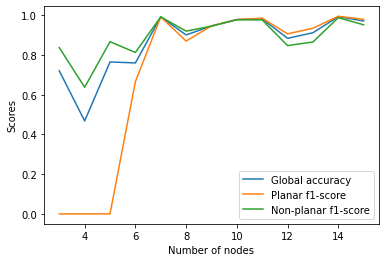


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  33.3% planar in average
Generated graphs with   7 nodes are at  37.5% planar in average
Generated graphs with   8 nodes are at  80.0% planar in average
Generated graphs with   9 nodes are at  36.4% planar in average
Generated graphs with  10 nodes are at  46.2% planar in average
Generated graphs with  11 nodes are at  28.6% planar in average
Generated graphs are at  47.8% planar in average

	# 2. Train model



  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 90.976% ± 11.360% for C=10.0


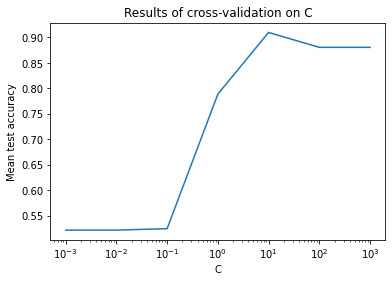

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/67 [00:00<?, ?it/s]

[[35  0]
 [ 2 30]]
              precision    recall  f1-score   support

  Non-planar       0.95      1.00      0.97        35
      Planar       1.00      0.94      0.97        32

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67


	### Score: 97.01% (f1-score for planar: 0.968 & non-planar: 0.972)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 280]
 [  0 720]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       280
      Planar       0.72      1.00      0.84       720

    accuracy                           0.72      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.52      0.72      0.60      1000


	### Score: 72.00% (f1-score for planar: 0.837 & non-planar: 0.000)

	### 4 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[  0 323]
 [  0 677]]
              precision    recall  f1-score   support

  Non-planar       0.00      0.00      0.00       323
      Planar       0.68      1.00      0.81       677

    accuracy                           0.68      1000
   macro avg       0.34      0.50      0.40      1000
weighted avg       0.46      0.68      0.55      1000


	### Score: 67.70% (f1-score for planar: 0.807 & non-planar: 0.000)

	### 5 NODES ###


/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[198  37]
 [  0 765]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.84      0.91       235
      Planar       0.95      1.00      0.98       765

    accuracy                           0.96      1000
   macro avg       0.98      0.92      0.95      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.30% (f1-score for planar: 0.976 & non-planar: 0.915)

	### 6 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[239 298]
 [ 87 376]]
              precision    recall  f1-score   support

  Non-planar       0.73      0.45      0.55       537
      Planar       0.56      0.81      0.66       463

    accuracy                           0.61      1000
   macro avg       0.65      0.63      0.61      1000
weighted avg       0.65      0.61      0.60      1000


	### Score: 61.50% (f1-score for planar: 0.661 & non-planar: 0.554)

	### 7 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[458   0]
 [ 46 496]]
              precision    recall  f1-score   support

  Non-planar       0.91      1.00      0.95       458
      Planar       1.00      0.92      0.96       542

    accuracy                           0.95      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.96      0.95      0.95      1000


	### Score: 95.40% (f1-score for planar: 0.956 & non-planar: 0.952)

	### 8 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[409  42]
 [ 12 537]]
              precision    recall  f1-score   support

  Non-planar       0.97      0.91      0.94       451
      Planar       0.93      0.98      0.95       549

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 94.60% (f1-score for planar: 0.952 & non-planar: 0.938)

	### 9 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[480  65]
 [  0 455]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.88      0.94       545
      Planar       0.88      1.00      0.93       455

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.93      1000
weighted avg       0.94      0.94      0.94      1000


	### Score: 93.50% (f1-score for planar: 0.933 & non-planar: 0.937)

	### 10 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[502  40]
 [  0 458]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.93      0.96       542
      Planar       0.92      1.00      0.96       458

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 96.00% (f1-score for planar: 0.958 & non-planar: 0.962)

	### 11 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[608  38]
 [  0 354]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.94      0.97       646
      Planar       0.90      1.00      0.95       354

    accuracy                           0.96      1000
   macro avg       0.95      0.97      0.96      1000
weighted avg       0.97      0.96      0.96      1000


	### Score: 96.20% (f1-score for planar: 0.949 & non-planar: 0.970)

	### 12 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[576 135]
 [  0 289]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.81      0.90       711
      Planar       0.68      1.00      0.81       289

    accuracy                           0.86      1000
   macro avg       0.84      0.91      0.85      1000
weighted avg       0.91      0.86      0.87      1000


	### Score: 86.50% (f1-score for planar: 0.811 & non-planar: 0.895)

	### 13 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[630 111]
 [  0 259]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.85      0.92       741
      Planar       0.70      1.00      0.82       259

    accuracy                           0.89      1000
   macro avg       0.85      0.93      0.87      1000
weighted avg       0.92      0.89      0.89      1000


	### Score: 88.90% (f1-score for planar: 0.824 & non-planar: 0.919)

	### 14 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[703  28]
 [  0 269]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.96      0.98       731
      Planar       0.91      1.00      0.95       269

    accuracy                           0.97      1000
   macro avg       0.95      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.20% (f1-score for planar: 0.951 & non-planar: 0.980)

	### 15 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/1000 [00:00<?, ?it/s]

[[686  60]
 [  0 254]]
              precision    recall  f1-score   support

  Non-planar       1.00      0.92      0.96       746
      Planar       0.81      1.00      0.89       254

    accuracy                           0.94      1000
   macro avg       0.90      0.96      0.93      1000
weighted avg       0.95      0.94      0.94      1000


	### Score: 94.00% (f1-score for planar: 0.894 & non-planar: 0.958)


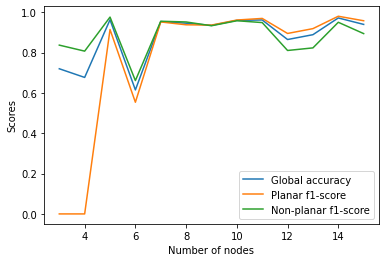


	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at 100.0% planar in average
Generated graphs with   6 nodes are at  60.0% planar in average
Generated graphs with   7 nodes are at  42.9% planar in average
Generated graphs with   8 nodes are at  62.5% planar in average
Generated graphs with   9 nodes are at  44.4% planar in average
Generated graphs with  10 nodes are at  27.3% planar in average
Generated graphs with  11 nodes are at  41.7% planar in average
Generated graphs with  12 nodes are at  46.2% planar in average
Generated graphs are at  47.8% planar in average

	# 2. Train model



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_splits=10, n_repeats=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 93.571% ± 9.485% for C=1000.0


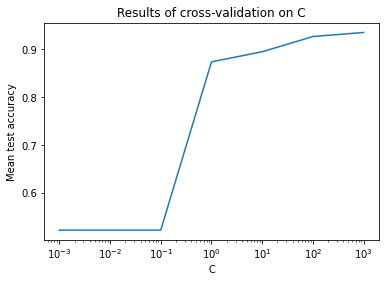

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=47),
             estimator=SVC(kernel='precomputed', random_state=76), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=weighted)})

	# 3. Smoke-test model



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

dist1 loop:   0%|          | 0/69 [00:00<?, ?it/s]

[[36  0]
 [ 0 33]]
              precision    recall  f1-score   support

  Non-planar       1.00      1.00      1.00        36
      Planar       1.00      1.00      1.00        33

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


	### Score: 100.00% (f1-score for planar: 1.000 & non-planar: 1.000)

	#   b. Ramping up number of nodes


	### 3 NODES ###


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from qplanarity import test_suite

times = [2.1, 1.6]
pulses = [0.2, 0.1]
train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'
metric = 'f1-score'
N = 100

scores = []
max_ns = range(5, 16)
test_ramping_max_n = 16
for max_n in tqdm(max_ns):
    train_ns = list(range(5, max_n + 1))
    train_nbs = generate_nbs(3, max_n, N)
    scores_loop = test_suite(times, pulses, train_ns, train_nbs, generator, seed=21, metric=metric, test_big=False, test_ramping_max_n=test_ramping_max_n)
    scores.append(scores_loop)

In [66]:
scores

[[(1.0, 1, 1), (1.0, 1, 1)], [(0.722, 0.0, 0.8385598141695703), (1.0, 1, 1)]]

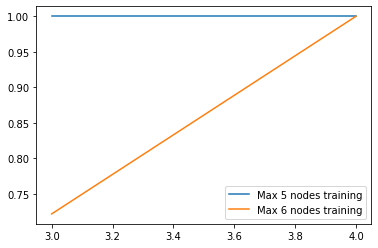

In [70]:
for n, all_scores_n in zip(max_ns, scores):
    scores_n = np.array(all_scores_n)[:, 0]
    plt.plot(list(range(3, test_ramping_max_n)), scores_n, label=f"Max {n} nodes training")
plt.legend()
plt.show()